# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

## 01 Import Libraries and Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight') 

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'DELETED API KEY'

In [3]:
# Importing the Federal Reserve Economic Data "Real Potential Gross Domestic Product" variable.

data = quandl.get('FRED/GDPPOT')

## 02 Data Wrangling

In [4]:
data.head(5)

,Value
Date,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


In [5]:
data.shape

(332, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

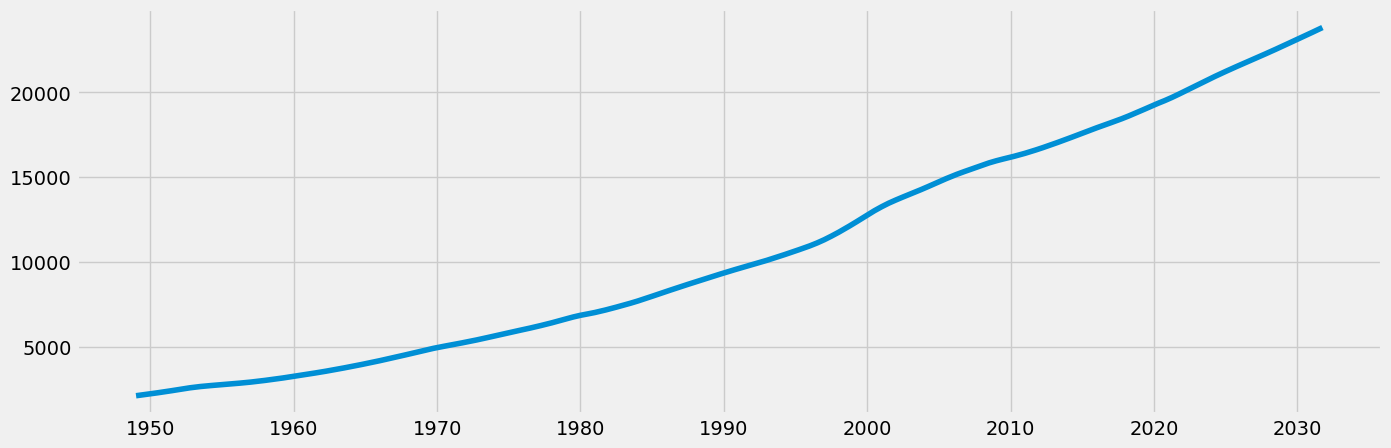

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530
3,1949-10-01,2186.844859
4,1950-01-01,2216.058359


## 03 Subset and clean up

In [11]:
data_sub = data_2.loc[(data_2['Date'] < '2022-10-01')]

Since the data is a consistant line going up so I am keeping all the data except after October 2022 since that is in the future.

In [12]:
data_sub.shape

(295, 2)

In [13]:
data_sub.head()

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530
3,1949-10-01,2186.844859
4,1950-01-01,2216.058359


In [14]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


## 04 Line Chart

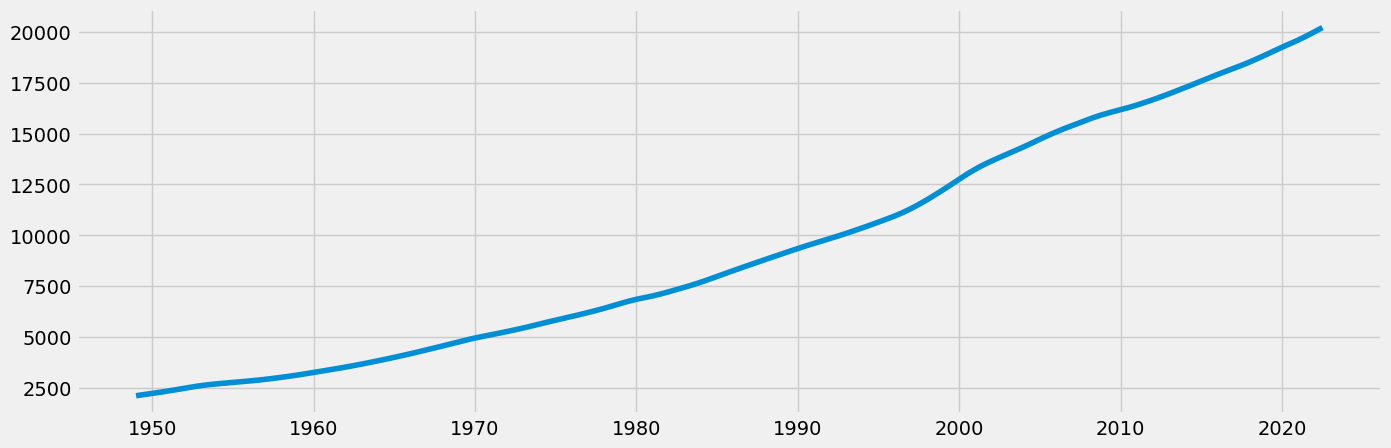

In [15]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [17]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

## 05 Time-series analysis: decomposition

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

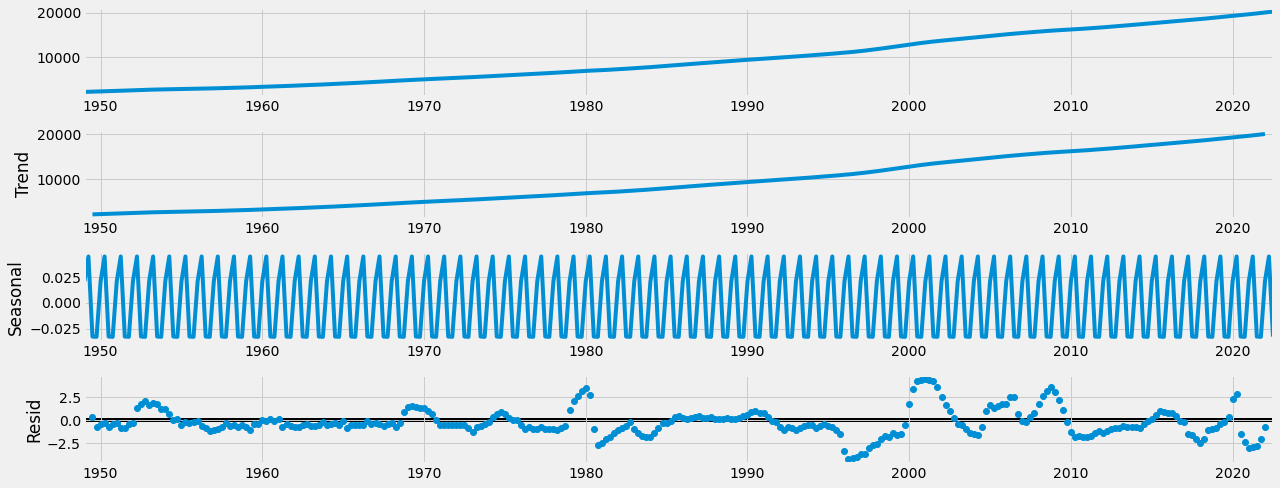

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

It is an upward trend and a steady seasonality. There are some residual. The plot does not look stationary.

## 06 Conduct a Dickey-Fuller test to check for stationarity

In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.946735
p-value                          0.998600
Number of Lags Used              5.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64


The Test Statistic is higher than Critical Value (5%) and the p-value is more than 0.05. It means the null hypothesis cannot be rejected. Also, the result is not significant since the p-value is more than 0.05.

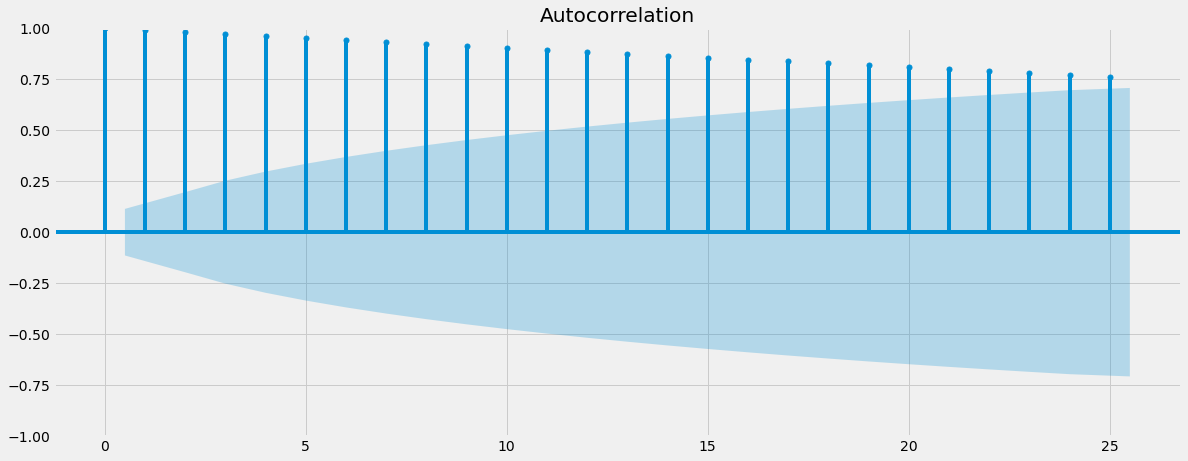

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

The lags in the series are above the blue edge of the confidence interval. This mean the lags are significantly correlated with each other. Therefore, the data is non-stationary.

## 07 Stationarizing the Federal Reserve Economic Data

In [23]:
data_2 = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [24]:
data_2.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [25]:
data_2.head()

,Value
datetime,
1949-04-01,27.598675
1949-07-01,28.759225
1949-10-01,27.504329
1950-01-01,29.213500
1950-04-01,29.423311


In [26]:
data_2.columns

Index(['Value'], dtype='object')

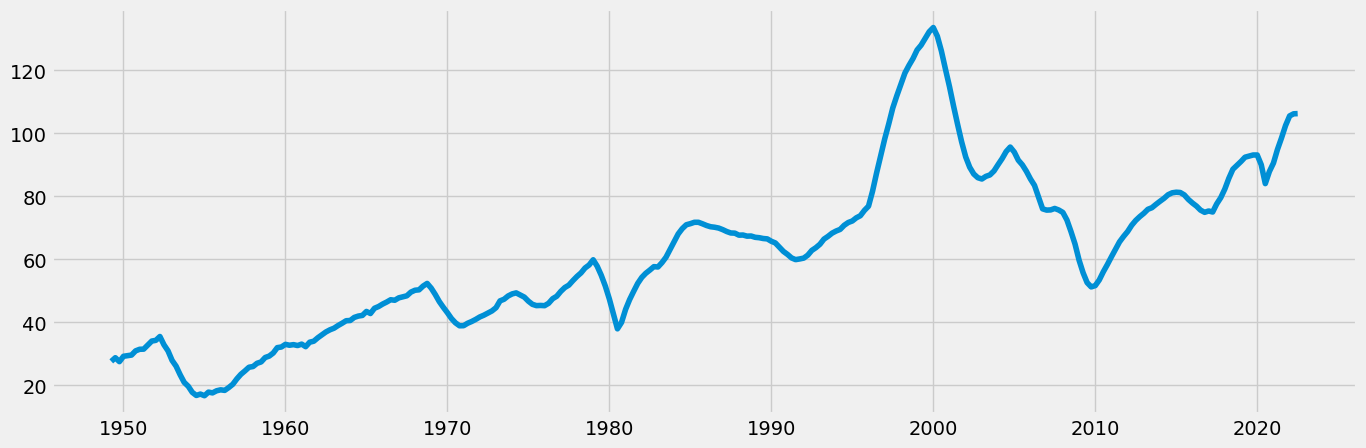

In [27]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_2)

In [28]:
dickey_fuller(data_2)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.401264
p-value                          0.581670
Number of Lags Used              5.000000
Number of Observations Used    288.000000
Critical Value (1%)             -3.453262
Critical Value (5%)             -2.871628
Critical Value (10%)            -2.572146
dtype: float64


The test statistic is still higher than the critical value (5%) and the p-value is also higher then 0.05. Therefore we will have to differencing again.

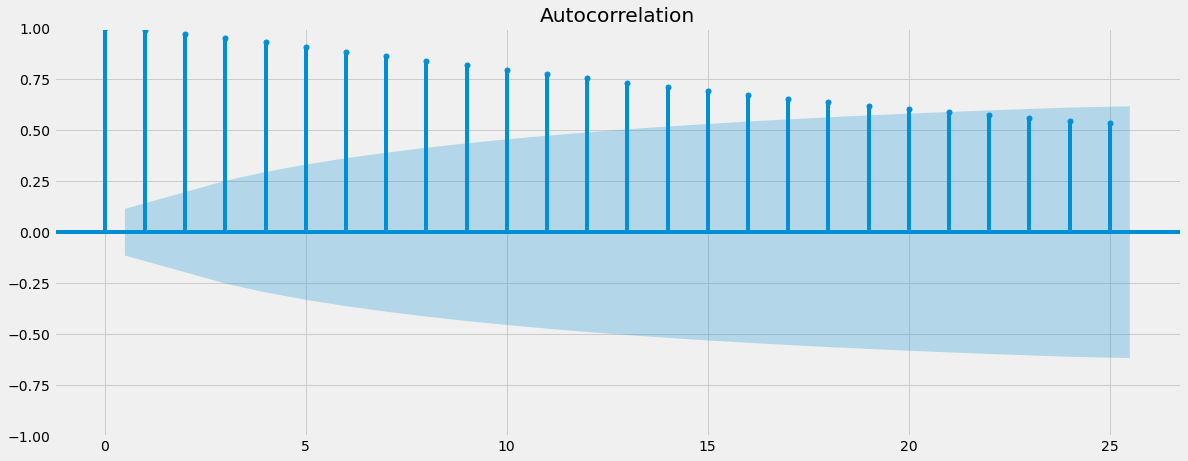

In [29]:
plot_acf(data_2)
plt.show()

There are still many lags T above the blue edge of the confidence interval. So the data is still non-stationary.

## 08 repeating differencing for Stationarizing

In [30]:
data_3 = data_2 - data_2.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [31]:
data_3.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [32]:
data_3.head()

,Value
datetime,
1949-07-01,1.160550
1949-10-01,-1.254896
1950-01-01,1.709171
1950-04-01,0.209811
1950-07-01,0.177320


In [33]:
data_3.columns

Index(['Value'], dtype='object')

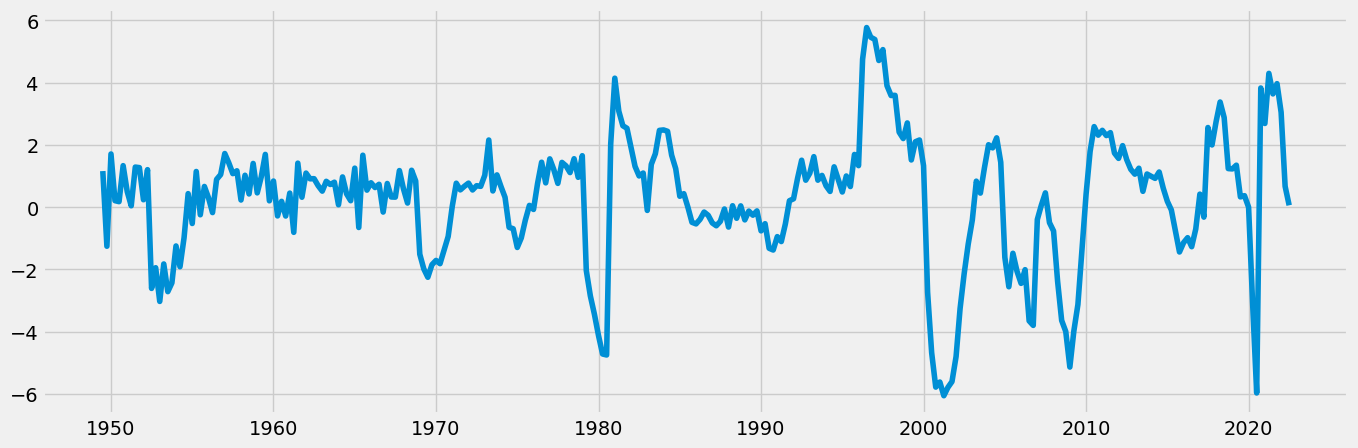

In [34]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_3)

In [35]:
dickey_fuller(data_3)

Dickey-Fuller Stationarity test:
Test Statistic                -6.176806e+00
p-value                        6.600319e-08
Number of Lags Used            3.000000e+00
Number of Observations Used    2.890000e+02
Critical Value (1%)           -3.453182e+00
Critical Value (5%)           -2.871593e+00
Critical Value (10%)          -2.572127e+00
dtype: float64


Test statistic is lower than critical value (5%) and p-value is lower than 0.05. so this is stationary. Therefore, the result is significant and the null hypothesis can be rejected.

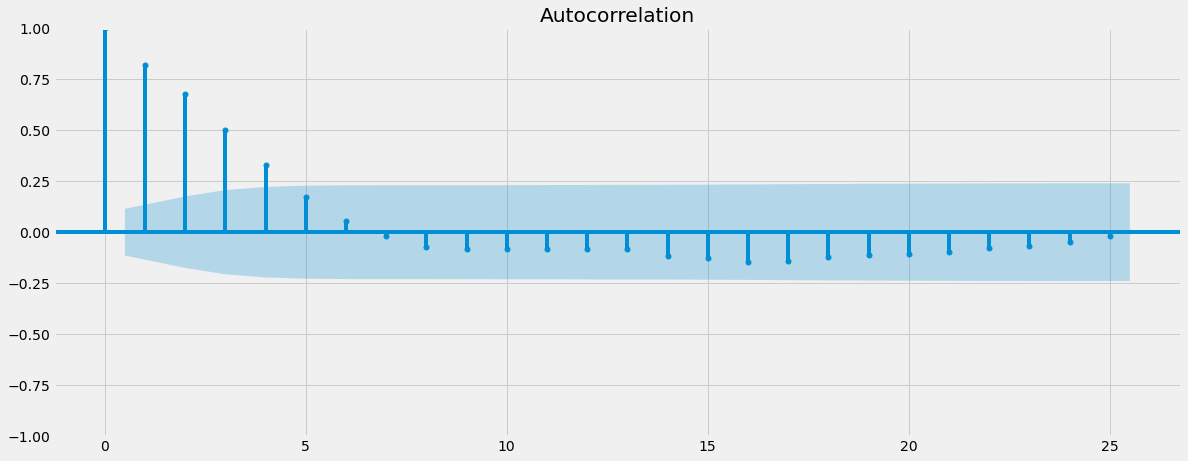

In [36]:
plot_acf(data_3)
plt.show()

The autocorrelation has less lags outside the blue edge of the confidence interval. this means the data is stationary.